# Oil well location

Let's say you work for the mining company GlavRosGosNeft. We need to decide where to drill a new well.

You have been provided with oil samples in three regions: in each of 10,000 deposits, where the quality of oil and the volume of its reserves have been measured. Build a machine learning model to help determine the region where mining will bring the most profit. Analyze possible profits and risks using the *Bootstrap* technique.

Steps to choose a location:

- In the selected region, they are looking for deposits, and for each, the value of the features are determined;
- Build a model and estimate the volume of reserves;
- Select the deposits with the highest value estimates. The number of fields depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected deposits.

## Loading and preparing data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# CONSTANTS
RANDOM_STATE = 654321
REGIONAL_BUDGET_RUB = 10000000000 
BARREL_PROFIT_RUB = 450000
BEST_FOR_DEV_CNT = 200 
CHECK_CNT = 500 
BOOTSTRAP_CNT = 1000
ERROR_COEF = 0.025
QUANTILE_975 = 0.975
QUANTILE_025 = 0.025

In [3]:
# file download
try:
    geo_0 = pd.read_csv('datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('datasets/geo_data_2.csv')
    print('Files read correctly')
except:
    print(f'Error reading the files')
    

Files read correctly


Let's look at the data for each region

### First look

#### Geo 0

In [4]:
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are no obvious empty values.

In [6]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


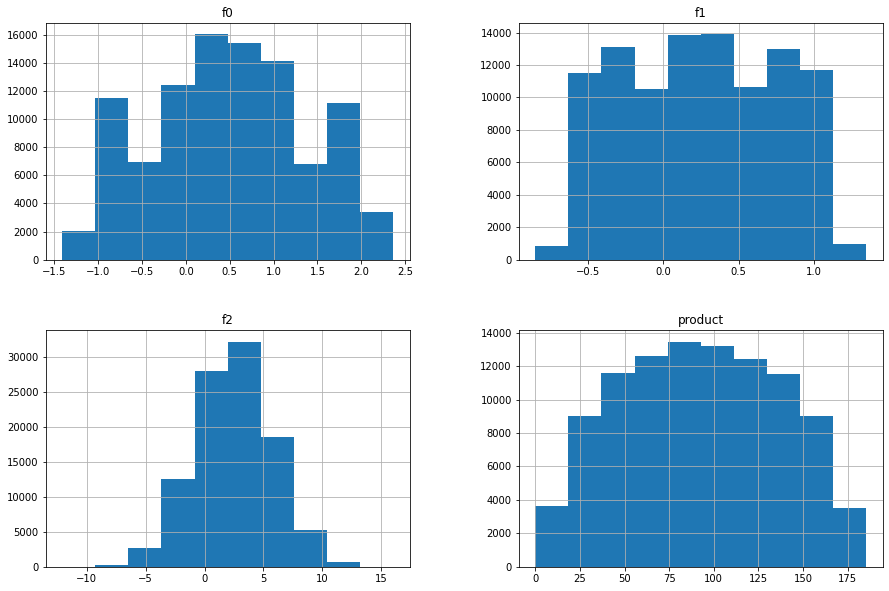

In [7]:
geo_0.hist(figsize=(15,10))
plt.show()

We see mostly a normal distribution everywhere

#### Geo 1

In [8]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are no obvious empty values.

In [10]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


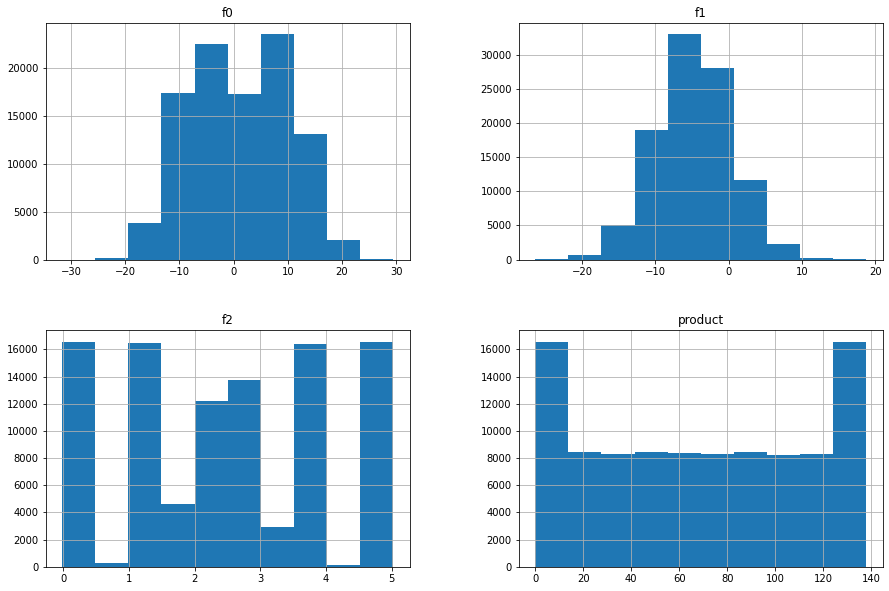

In [11]:
geo_1.hist(figsize=(15,10))
plt.show()

Only f0 and f1 are normally distributed, while f2 is all over the place. The volume of reserves in the well is mostly evenly distributed.

#### Geo 2

In [12]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [13]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


There are no obvious empty values.

In [14]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


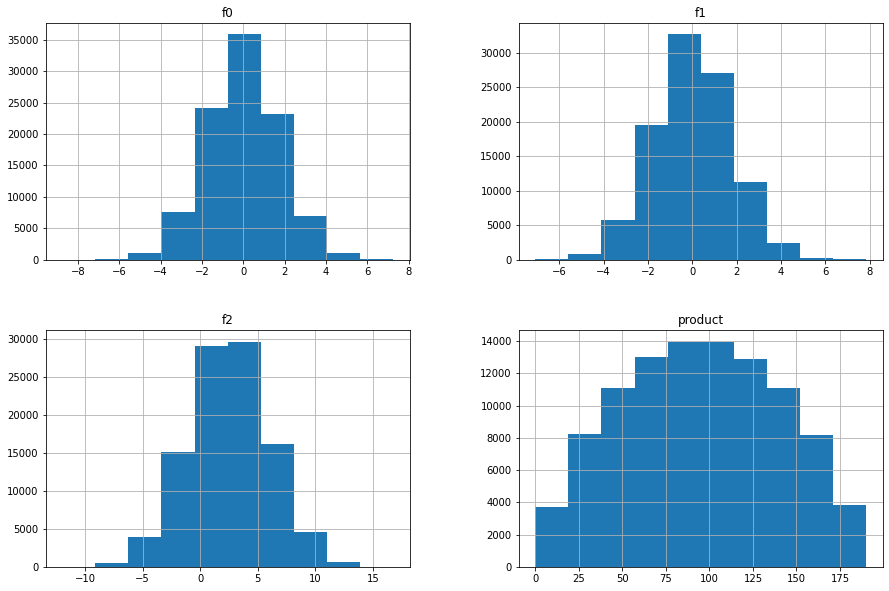

In [15]:
geo_2.hist(figsize=(15,10))
plt.show()

Mostly normal distribution 

#### Results

<li>In general, we see that the Geo_0 and Geo_2 regions have a normal distribution, while the Geo_1 region does not.</li>
<li>No empty values in any of the datasets</li> 
<li>The value of f0, f1, and f2 within each region needs to be scaled</li>

### Data preprocessing

Let's prepare our data for training

#### Column: id

Do we need column "id"?

In [16]:
len(geo_0['id'].unique())

99990

In [17]:
len(geo_1['id'].unique())

99996

In [18]:
len(geo_1['id'].unique())

99996

There are duplicate ids, let's look at them

In [19]:
geo_0[geo_0['id'].duplicated(keep=False)].sort_values(by='id').head(10)

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


It does not carry any relevant info for our purposes. In general, the column can be deleted!

In [20]:
geo_0 = geo_0.drop(['id'], axis=1)
geo_1 = geo_1.drop(['id'], axis=1)
geo_2 = geo_2.drop(['id'], axis=1)

In [21]:
geo_0.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

In [22]:
geo_1.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

In [23]:
geo_2.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

#### Duplicates

Check for obvious duplicates

In [24]:
geo_0.duplicated().sum()

0

In [25]:
geo_1.duplicated().sum()

0

In [26]:
geo_2.duplicated().sum()

0

No duplicates - good.

In general, we got fairly clean data

## Train and validate the model

Now we divide our regions into training and validation sets, scale the data and train our models

### Dividing into sets

Divide into sets. Ratio 75:25

#### Geo 0

In [27]:
features_geo_0 = geo_0.drop(['product'], axis=1)
target_geo_0 = geo_0['product']

In [28]:
f'{features_geo_0.shape}, {target_geo_0.shape}'

'(100000, 3), (100000,)'

In [29]:
features_train_geo_0, features_valid_geo_0, target_train_geo_0, target_valid_geo_0 = (
    train_test_split(features_geo_0, target_geo_0, test_size=0.25, random_state=RANDOM_STATE)
)

In [30]:
f'''Train: \
{features_train_geo_0.shape[0]}, \
{target_train_geo_0.shape[0]}, \
{round(features_train_geo_0.shape[0]/geo_0.shape[0]*100, 2)}%'''

'Train: 75000, 75000, 75.0%'

In [31]:
f'''Validation: \
{features_valid_geo_0.shape[0]}, \
{target_valid_geo_0.shape[0]}, \
{round(features_valid_geo_0.shape[0]/geo_0.shape[0]*100, 2)}%'''

'Validation: 25000, 25000, 25.0%'

#### Geo 1

In [32]:
features_geo_1 = geo_1.drop(['product'], axis=1)
target_geo_1 = geo_1['product']

In [33]:
f'{features_geo_1.shape}, {target_geo_1.shape}'

'(100000, 3), (100000,)'

In [34]:
features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1 = (
    train_test_split(features_geo_1, target_geo_1, test_size=0.25, random_state=RANDOM_STATE)
)

In [35]:
f'''Train: \
{features_train_geo_1.shape[0]}, \
{target_train_geo_1.shape[0]}, \
{round(features_train_geo_1.shape[0]/geo_1.shape[0]*100, 2)}%'''

'Train: 75000, 75000, 75.0%'

In [36]:
f'''Validation: \
{features_valid_geo_1.shape[0]}, \
{target_valid_geo_1.shape[0]}, \
{round(features_valid_geo_1.shape[0]/geo_1.shape[0]*100, 2)}%'''

'Validation: 25000, 25000, 25.0%'

#### Geo 2

In [37]:
features_geo_2 = geo_2.drop(['product'], axis=1)
target_geo_2 = geo_2['product']

In [38]:
f'{features_geo_2.shape}, {target_geo_2.shape}'

'(100000, 3), (100000,)'

In [39]:
features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2 = (
    train_test_split(features_geo_2, target_geo_2, test_size=0.25, random_state=RANDOM_STATE)
)

In [40]:
f'''Train: \
{features_train_geo_2.shape[0]}, \
{target_train_geo_2.shape[0]}, \
{round(features_train_geo_2.shape[0]/geo_2.shape[0]*100, 2)}%'''

'Train: 75000, 75000, 75.0%'

In [41]:
f'''Validation: \
{features_valid_geo_2.shape[0]}, \
{target_valid_geo_2.shape[0]}, \
{round(features_valid_geo_2.shape[0]/geo_2.shape[0]*100, 2)}%'''

'Validation: 25000, 25000, 25.0%'

The data has been successfully divided into sets and features!

### Scaling

Since we assume that all features are equal, we need to scale them

In [42]:
pd.options.mode.chained_assignment = None
scaler_0 = StandardScaler()
scaler_0.fit(features_train_geo_0)

features_train_geo_0[features_train_geo_0.columns] = scaler_0.transform(features_train_geo_0[features_train_geo_0.columns])
features_valid_geo_0[features_valid_geo_0.columns] = scaler_0.transform(features_valid_geo_0[features_valid_geo_0.columns])

In [43]:
pd.options.mode.chained_assignment = None
scaler_1 = StandardScaler()
scaler_1.fit(features_train_geo_1)

features_train_geo_1[features_train_geo_1.columns] = scaler_1.transform(features_train_geo_1[features_train_geo_1.columns])
features_valid_geo_1[features_valid_geo_1.columns] = scaler_1.transform(features_valid_geo_1[features_valid_geo_1.columns])


In [44]:
pd.options.mode.chained_assignment = None
scaler_2 = StandardScaler()
scaler_2.fit(features_train_geo_2)

features_train_geo_2[features_train_geo_2.columns] = scaler_2.transform(features_train_geo_2[features_train_geo_2.columns])
features_valid_geo_2[features_valid_geo_2.columns] = scaler_2.transform(features_valid_geo_2[features_valid_geo_2.columns])


Let's check the scaling.

In [45]:
features_train_geo_0.head()

,f0,f1,f2
78171,-1.424113,1.078794,0.837682
8445,-0.632297,0.400509,-0.512933
33255,1.325600,-0.865863,0.690793
74509,0.044165,-1.361556,-0.228982
42302,1.696325,0.455145,-0.398980


In [46]:
features_train_geo_1.head()

,f0,f1,f2
78171,1.485776,-0.074119,-1.461828
8445,-0.710000,1.023495,-1.463833
33255,0.737028,-0.590909,-1.463711
74509,1.495579,1.287452,-0.294239
42302,-0.162193,-0.057791,-1.463471


In [47]:
features_train_geo_2.head()

,f0,f1,f2
78171,0.788958,-1.116239,-0.447831
8445,0.415822,-1.995621,0.936335
33255,-0.314193,1.933984,0.681916
74509,-1.434135,-0.335875,-2.372988
42302,-1.830388,0.259886,-1.352166


Scaling appears to be correct!

### Training

Let's train linear regression model as it is the most predictable one.

In [48]:
# the function finds the MSE and RMSE of the region
# returns the prediction
def find_best_linear_model(features_train, features_valid, target_train, target_valid): 
    best_linear_model = None
    best_linear_mse = 0
    best_linear_rmse = 0
    best_mean_rmse = 0
    best_mean_mse = 0

    model_linear = (LinearRegression())
    model_linear.fit(features_train, target_train)
    predicted_valid = model_linear.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid) 
    rmse = mse ** 0.5


    best_linear_model = model_linear
    best_linear_rmse = rmse
    best_linear_mse = mse
    predicted_valid_mean = pd.Series(target_train.mean(), index=target_valid.index)
    best_mean_mse = mean_squared_error(target_valid, predicted_valid_mean)
    best_mean_rmse = best_mean_mse ** 0.5

    linear_final_result = {'rmse_linear':round(best_linear_rmse,5),
                           'mse_linear':round(best_linear_mse,5),
                           'rmse_mean':round(best_mean_rmse),
                           'mse_mean':round(best_mean_mse,5),
                          }
    return linear_final_result, predicted_valid

Now let's look at the results of the function for each region

#### Geo 0

In [49]:
geo_0_result, geo_0_predicted_valid = find_best_linear_model(
    features_train_geo_0, features_valid_geo_0, target_train_geo_0, target_valid_geo_0
)

In [50]:
geo_0_result

{'rmse_linear': 37.62574,
 'mse_linear': 1415.69612,
 'rmse_mean': 44,
 'mse_mean': 1966.04237}

In [51]:
geo_0_predicted_valid.mean()

92.6715348997113

In [52]:
pd.Series(geo_0_predicted_valid).median()

92.69058326545836

<li>We see that the average error is somewhere around 37 thousand barrels</li>
<li>It is not much different from the average error.</li>
<li>Average predicted barrels = 92,000 barrels</li>

#### Geo 1

In [53]:
geo_1_result, geo_1_predicted_valid  = find_best_linear_model(
    features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1
)

In [54]:
geo_1_result

{'rmse_linear': 0.89197,
 'mse_linear': 0.79561,
 'rmse_mean': 46,
 'mse_mean': 2111.36969}

In [55]:
geo_1_predicted_valid.mean()

68.86474583931854

In [56]:
pd.Series(geo_1_predicted_valid).median()

58.144779785577676

<li>We see that the average error is less than one thousand barrels.</li>
<li>Average predicted barrels = 68,000 barrels</li>

#### Geo 2

In [57]:
geo_2_result, geo_2_predicted_valid = find_best_linear_model(
    features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2
)

In [58]:
geo_2_result

{'rmse_linear': 40.28173,
 'mse_linear': 1622.61747,
 'rmse_mean': 45,
 'mse_mean': 2032.16996}

In [59]:
geo_2_predicted_valid.mean()

95.11667011841202

In [60]:
pd.Series(geo_2_predicted_valid).median()

95.12448811288374

<li>We see that the average error is about 40 thousand barrels</li>
<li>It is not much different from the average error.</li>
<li>Average predicted barrels = 95,000 barrels</li>

## Preparing for profit calculation

Let's find a sufficient volume of raw materials for the break-even development of a new well

In [61]:
min_barrel_in_region = math.ceil(REGIONAL_BUDGET_RUB / BARREL_PROFIT_RUB) 

In [62]:
f'The minimum number of barrels in the region should be equal to {min_barrel_in_region:,} thousands'

'The minimum number of barrels in the region should be equal to 22,223 thousands'

In [63]:
barrel_per_place = min_barrel_in_region / BEST_FOR_DEV_CNT

In [64]:
f'One well must have an average of {barrel_per_place} thousand barrels to break even'

'One well must have an average of 111.115 thousand barrels to break even'

Let's compare these values with the average real values in wells in the regions

In [65]:
f'Geo 0: {round(target_geo_0.mean(), 5)}'

'Geo 0: 92.5'

In [66]:
f'Geo 1: {round(target_geo_1.mean(), 5)}'

'Geo 1: 68.825'

In [67]:
f'Geo 2: {round(target_geo_2.mean(), 5)}'

'Geo 2: 95.0'

In all three regions, the average number of barrels per well is less than we need to break even

## Calculation of profit and risks

Calculate profit based on predictions, find risks, and average model error

### Predicted profits

In [68]:
# accepts as input equal length samples of real and predicted values, and the number of wells for selection
# find top values from predictions 
# based on that, we find the corresponding real values by the index, and find the profit
def profit(target, predicted, count):
    predicted_indexed = pd.Series(predicted, index=target.index)
    predicted_sorted = predicted_indexed.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:count]
    return sum(BARREL_PROFIT_RUB * selected) - REGIONAL_BUDGET_RUB

In [69]:
geo_0_predicted_profit = profit(target_valid_geo_0, geo_0_predicted_valid, BEST_FOR_DEV_CNT)

In [70]:
f'Profits for Geo 0 = {geo_0_predicted_profit:,}'

'Profits for Geo 0 = 3,468,372,851.144161'

In [71]:
geo_1_predicted_profit = profit(target_valid_geo_1, geo_1_predicted_valid, BEST_FOR_DEV_CNT)

In [72]:
f'Profits for Geo 1 = {geo_1_predicted_profit:,}'

'Profits for Geo 1 = 2,415,086,696.6815624'

In [73]:
geo_2_predicted_profit = profit(target_valid_geo_1, geo_2_predicted_valid, BEST_FOR_DEV_CNT)

In [74]:
f'Profits for Geo 2 = {geo_2_predicted_profit:,}'

'Profits for Geo 2 = -4,007,232,675.5251904'

On Geo 0 and 1 we have a profit, but in Geo 2 we have a significant loss.

### Risks

In [75]:
state = np.random.RandomState(RANDOM_STATE)

In [76]:
def bootstrap(target, predicted, count, check):
    values = []
    for i in range(count):
        target_subsample = target.sample(check, replace=True, random_state=state)
        predicted_subsample = pd.Series(predicted, index=target.index)[target_subsample.index]
        values.append(profit(target_subsample, predicted_subsample, BEST_FOR_DEV_CNT))

    values = pd.Series(values)
    
    upper = values.quantile(QUANTILE_975)
    lower = values.quantile(QUANTILE_025)
    mean = values.mean()
    risk = values < 0
    risk = risk.mean()
    
    return upper, lower, mean, risk

#### Geo 0

In [77]:
geo_0_upper, geo_0_lower, geo_0_mean, geo_0_risk = bootstrap(
    target_valid_geo_0, geo_0_predicted_valid, BOOTSTRAP_CNT, CHECK_CNT
)

In [78]:
f'Confidence interval: from {geo_0_lower:,} to {geo_0_upper:,}'

'Confidence interval: from -12,863,885.341850467 to 1,026,037,903.7974298'

In [79]:
f'Average profit: {geo_0_mean:,}'

'Average profit: 521,480,669.45672536'

In [80]:
f'Negative profit risk: {geo_0_risk}'

'Negative profit risk: 0.03'

In [81]:
f'Is the risk lower than required? {"Yes" if geo_0_risk < ERROR_COEF else "No"}'

'Is the risk lower than required? No'

#### Geo 1

In [82]:
geo_1_upper, geo_1_lower, geo_1_mean, geo_1_risk = bootstrap(
    target_valid_geo_1, geo_1_predicted_valid, BOOTSTRAP_CNT, CHECK_CNT
)

In [83]:
f'Confidence interval: from {geo_1_lower:,} to {geo_1_upper:,}'

'Confidence interval: from 90,989,931.04269214 to 943,521,059.1383471'

In [84]:
f'Average profit: {geo_1_mean:,}'

'Average profit: 509,670,940.7359877'

In [85]:
f'Negative profit risk: {geo_1_risk}'

'Negative profit risk: 0.01'

In [86]:
f'Is the risk lower than required? {"Yes" if geo_1_risk < ERROR_COEF else "No"}'

'Is the risk lower than required? Yes'

#### Geo 2

In [87]:
geo_2_upper, geo_2_lower, geo_2_mean, geo_2_risk = bootstrap(
    target_valid_geo_2, geo_2_predicted_valid, BOOTSTRAP_CNT, CHECK_CNT
)

In [88]:
f'Confidence interval: from {geo_2_lower:,} to {geo_2_upper:,}'

'Confidence interval: from -123,862,009.55221796 to 993,899,253.4107847'

In [89]:
f'Average profit: {geo_2_mean:,}'

'Average profit: 439,399,844.2868845'

In [90]:
f'Negative profit risk: {geo_2_risk}'

'Negative profit risk: 0.06'

In [91]:
f'Is the risk lower than required? {"Yes" if geo_2_risk < ERROR_COEF else "No"}'

'Is the risk lower than required? No'

#### Results

<p>The risk of negative profit is the most reliable for Geo 1, as it is almost close to zero and below the required 2.5%</p>
<p>It also has the only 95% confidence interval in the positive.</p>
<p>Based on this, we conclude that Geo 1 is the most suitable region for our task.</p>

## Conclusion

<p>As part of this study, in order to find a region with maximum profitability, we did the following work: we loaded and processed the data, cleaning it from features that do not affect the model training. We split our data into training and validation sets and also scaled the features so that each of the three f-metrics was equal in significance.</p>

<p>Next, we trained a linear regression model and stored its predictions. Based on these predictions, we calculated the profit for each region. We found how many thousand barrels should be on average in each well in order for us to reach 0 profit and how many there are now. In all three regions, it was less than we need.</p>

<p>We used the bootstrap technique to find 500 random wells 1000 times in each region and found for each region: negative return risk, average return, and 95% confidence quintile.</p>

<p>Based on our study, we recommend region #1 as it is the only region with low risk of negative profit, high predicted profit, and positive values in the 95% confidence interval.</p>